# Project code
This is the main code file of the project. The scope of the project is to investigate the language, semantics and trends in the Harry Potter books. By using the books in pdf-format as datasource, I will attempt to create a model that takes a page without label and predicts what book it is from.

## Part 1: Loading PDF to Dataframe
The following cells loads the data into dataframes, and uses a extraction function to achieve the desired data structure.

In [1]:
import os
import re
import pandas as pd
import PyPDF2
from PyPDF2 import PdfReader,PdfWriter
def extract_clean_text(text):
    # replace tabs and newlines with a space
    text = text.replace('\t', ' ').replace('\n', ' ')
    # replace multiple spaces with a single space
    text = ' '.join(text.split())
    return text

In [2]:
def pdf_to_dataframe(pdf_path):
    data = []

    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        num_pages = len(reader.pages)

        for i in range(num_pages):
            page_text = reader.pages[i].extract_text()
            if page_text:
                clean_page_text = extract_clean_text(page_text)
                data.append({'Page': i + 1, 'Text': clean_page_text})

    df = pd.DataFrame(data)
    return df

## Part 2: Tokenizaton
Tokenize the text using spacy. 

In [3]:
import spacy

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Define the tokenizer function
def tokenization(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens


#### Data extraction
Using the above functions to first create separate dataframes for each book.

## Part 3: Book specific preprocessing
Since the books come in slightly different format, inspection has led to the conclusion that some manual preprocessing will be needed for some of the books to obtain similar structure for all dataframes.

### Common functions used for several books

In [4]:
# Define the function to extract header. Used for several books.
def extract_header(page_text):
    # Headers are defined as the first line of a page
    header = page_text.split('\n')[0]
    return header


def merge_split_words(text):
    # regex for finding and replacing the failed reading of words split by newline. 
    pattern = r'(\w+)- (\w+)'
    
    def merge_match(match):
        return match.group(1) + match.group(2)

    merged_text = re.sub(pattern, merge_match, text)

    return merged_text

# NOTE:
For all books, a threshold of 30 words is applied for the including of words in the dataframes. Furthermore, everytime a pattern is used for filtering out headers and such, It has been inspected to not interfer wit the actual data. For example, books 4 and 5 handle their uppercase lines with exceptions lists. At all places where no such exceptions are handled, it is because I made sure to check that it was not needed.

### Book 1
The first book requires the least effort, since it has no strange formats or chapter titles in the pages. We only extract the Chapter number an title and remove it when present, i.e in the beginning of chapters. This involves removing the two first rows if the page starts with "chapter".

In [11]:
def process_pdf_book_1(pdf_path):
    df = pd.DataFrame(columns=['Page', 'Text', 'Tokens'])
    data = []

    with pdfplumber.open(pdf_path) as pdf:
        num_pages = len(pdf.pages)

        for i in range(num_pages):
            page = pdf.pages[i]
            page_text = page.extract_text()
            if page_text: 
                header = extract_header(page_text)
                if header.lower().startswith("chapter"):
                    page_text = page_text.replace(header, '').strip()  # remove the chapter title
                    secondary_header = extract_header(page_text)
                    page_text = page_text.replace(secondary_header, '').strip()
                cleaned_page_text = extract_clean_text(page_text)
                cleaned_page_text = merge_split_words(cleaned_page_text)
                data.append({'Page': i + 1, 'Text': cleaned_page_text})

        df = pd.DataFrame(data)
    df['Tokens'] = df['Text'].apply(tokenization)

    # Filter out pages with less than 30 tokens
    df_filtered = df[df['Tokens'].apply(len) >= 30]
    
    return df_filtered

### Book 7
The last book in the series is a trickier version of book 1. Here, every page number is included by the pdf reader at the end of the page. This is removed by the first function. Furthermore, all pages here contain a header which is alternating between chapter number and chapter title. These cases are handled by the default extract_header function, but I needed to get rid of the ones initializing each new chapter. Since I could not identify a pattern to use for finding chapter beginnings and removing them, my only idea was to create a dictionary with all the chapters in order to check for matching sequences of text, and then remove them. Finally, the first two initial pages are dropped because they are copyright pages etc.

In [6]:
def remove_page_number_from_end(text):
    # Split the text into words
    words = text.split()

    # Just verifying that the last "word" on the page is indeed the page number.
    if words and words[-1].isdigit() and int(words[-1]) <= 999:
        # Remove the last word
        return ' '.join(words[:-1])
    return text
    
def remove_chapter_titles(text, chapter_titles):
    words = text.split()
    for i in range(1, 8): # Since the longest chapter name in this book is seven words, we do not need to search for a pattern after that.
        sequence = ' '.join(words[:i])
        if sequence in chapter_titles:
            return text.replace(sequence, '', 1).strip()
    return text
    


def process_pdf_book_7(pdf_path):
    # Dictionary of chapter titles, since there was no other pattern obvious to me on how
    # to identify and remove the chapter titles. For other books, there was always some uppercase pattern or such...
    chapter_titles = {
        "The Dark Lord Ascending": True,
        "In Memoriam": True,
        "The Dursleys Departing": True,
        "The Seven Potters": True,
        "Fallen Warrior": True,
        "The Ghoul in Pyjamas": True,
        "The Will of Albus Dumbledore": True,
        "The Wedding": True,
        "A Place to Hide": True,
        "Kreacher's Tale": True,
        "The Bribe": True,
        "Magic is Might": True,
        "The Muggle-Born Registration Commission": True,
        "The Thief": True,
        "The Goblin's Revenge": True,
        "Godric's Hollow": True,
        "Bathilda's Secret": True,
        "The Life and Lies of Albus Dumbledore": True,
        "The Silver Doe": True,
        "Xenophilius Lovegood": True,
        "The Tale of the Three Brothers": True,
        "The Deathly Hallows": True,
        "Malfoy Manor": True,
        "The Wandmaker": True,
        "Shell Cottage": True,
        "Gringotts": True,
        "The Final Hiding Place": True,
        "The Missing Mirror": True,
        "The Lost Diadem": True,
        "The Sacking of Severus Snape": True,
        "The Battle of Hogwarts": True,
        "The Elder Wand": True,
        "The Prince's Tale": True,
        "The Forest Again": True,
        "King's Cross": True,
        "The Flaw in the Plan": True
    }


    df = pd.DataFrame(columns=['Page', 'Text'])
    data = []

    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        num_pages = len(reader.pages)

        for i in range(num_pages):
            page_text = reader.pages[i].extract_text()
            if page_text:  # Check if the page contains text
                header = extract_header(page_text)
                page_text = page_text.replace(header, '').strip()  # Remove the initial header
                cleaned_page_text = extract_clean_text(page_text) 
                cleaned_page_text = remove_chapter_titles(cleaned_page_text, chapter_titles)  # Remove chapter titles
                cleaned_page_text = remove_page_number_from_end(cleaned_page_text)
                cleaned_page_text = merge_split_words(cleaned_page_text)
                data.append({'Page': i + 1, 'Text': cleaned_page_text})

    df = pd.DataFrame(data)
    df['Tokens'] = df['Text'].apply(tokenization)

    # Filter out pages with less than 30 tokens
    df_filtered = df[df['Tokens'].apply(len) >= 30]

    # Dropping the copyright pages etc.
    df_final = df_filtered.drop(df_filtered.index[0]).reset_index(drop=True)
    df_final = df_final.drop(df_final.index[0]).reset_index(drop=True)

    return df_final[['Page', 'Text', 'Tokens']]

### Book 2 & 6
The struggle here is that all pages start with the same format containing the page and the title. Thses are handled by the two functions below. Furthermore, I had to construct a way of identifying the chapter names initializing chapters. The pattern I discovered was the uppercase format of chapter titles, which allowed for removing the intial sequence of upper case words to make sure they are not included in the dataframe.

In [7]:

def remove_header_for_book_2(text, page_number):
    if page_number < 100:
        # Pattern for pages 1-99
        header_pattern = f"P a g e \| {page_number} Harry Potter and the Chamber of Secrets – J.K[ .]*Rowling"
        cleaned_text = re.sub(header_pattern, '', text, flags=re.IGNORECASE)
    else:
        # Pattern for the rest. ChatGPT helped me debug and find the additional space in the title above page 99, 
        # could have taken me a lifetime to find manually...
        header_pattern = f"P a g e \| {page_number} Harry Potter and the Chamber of Secrets – J. K[ .]*Rowling"
        cleaned_text = re.sub(header_pattern, '', text, flags=re.IGNORECASE | re.DOTALL)
    
    # Perform the removal of chapter titles.
    return remove_chapter_titles_book_2_and_6(cleaned_text, ['ARAGOG'])   



def remove_header_for_book_6(text, page_number):
    special_titles = ['SECTUMSEMPRA', 'HORCRUXES']
    if page_number < 100:
        header_pattern = f"P a g e \| {page_number} Harry Potter and the Half Blood Prince – J.K. Rowling"
    else:
        header_pattern = f"P a g e \| {page_number} Harry Potter and the Half Blood Prince – J.K[ .]*Rowling"

    cleaned_text = re.sub(header_pattern, '', text, flags=re.IGNORECASE | re.DOTALL)
    
    return remove_chapter_titles_book_2_and_6(cleaned_text, ['SECTUMSEMPRA', 'HORCRUXES'])
    

def remove_chapter_titles_book_2_and_6(cleaned_text, special_titles):
    words = cleaned_text.strip().split()
    uppercase_sequence = []
    for word in words:
        if word.isupper():
            uppercase_sequence.append(word)
        else:
            break  # Stop if a word is not uppercase
            
    # The function is designed to find the end of the title, which will be one uppercase token. To handel the 
    # Chapter names that are actually one word, these are passed as an array since they where so few.
    if len(uppercase_sequence) > 1 or (len(uppercase_sequence) == 1 and uppercase_sequence[0] in special_titles):
        uppercase_text = ' '.join(uppercase_sequence)
        cleaned_text = cleaned_text.replace(uppercase_text, '', 1).strip()
    return merge_split_words(cleaned_text.strip())


def process_pdf_book_2_6(pdf_path, header_function):
    df = pdf_to_dataframe(pdf_path)

    # The only thing differing is the header function, so this is passed into this preprocessing funciton from 
    # outside.
    df['Text'] = df.apply(lambda row: header_function(row['Text'], row['Page']), axis=1)

    df['Tokens'] = df['Text'].apply(tokenization)

    # Filter out pages with less than 30 tokens
    df_filtered = df[df['Tokens'].apply(len) >= 30]

    final_df = df_filtered[['Page', 'Text', 'Tokens']]
    return final_df

### Book 4 & Book 5
Here, the pages also contain the chapter number (in text format) or the chapter name on top of the pages. Additionally, each page has the page number in the bottom of the page and a cid format. Finally, a rather strange pattern was identified after debugging the tokenization of the pages: In these books they are using a special, large font for the first letter in a new chapter. When a chapter starts with a sentence like "Harry woke up..." the pdf-reader reads it as "arry woke up", and then appends the "H" as its own line between the chapter title and the actual text. This is fixed by identifying a row that is only uppercase but only one character, and then appending it in the beginning of the next word, restoring the actual text. 

In [8]:
import pdfplumber
import pandas as pd

def remove_cid_and_page_number(text):
    lines = text.split('\n')

    # Remove the last line if it contains "(cid:145)". Just an identified pattern in these books with the new pdf reader.
    if lines and "(cid:145)" in lines[-1]:
        lines = lines[:-1]

    # Join the lines again
    cleaned_text = '\n'.join(lines)

    #remove the page number from the end
    cleaned_text = remove_page_number_from_end(cleaned_text)

    return cleaned_text

def process_uppercase_lines(text, page_number, one_line_pages, two_line_pages):
    lines = text.split('\n')
    new_text = []
    append_next_line = False  # Bool to check if we need to append to the next line
    char_to_append = ""

    # These are the cases when the actual text of a page starts with only uppercase letters in that row,
    # in that case we want to keep it. These pages where identified by inspection of debug prints,
    # And the only solution i came up with was passing the page numbers and solve it this way.
    # one_line_pages contain the pages where there is an uppercase sequence we shall keep, and the chapter title is only one 
    # line. In such case, remove one line. The other array is for two line chapter titles.
    if page_number in one_line_pages:
        new_text = lines[1:]  # Skip the first line
    elif page_number in two_line_pages:
        new_text = lines[2:]  # Skip the first two lines
    else:
        # Otherwise, remove all initial uppercase lines. This function also locates the lost character that is actually part
        # of the very first word in the text. 
        for index, line in enumerate(lines):
            if line.isupper():
                if len(line) == 1 and index + 1 < len(lines):  # Check for single character line
                    append_next_line = True
                    char_to_append = line[0]
            else:
                if append_next_line:
                    # Append single uppercase character to the beginning of the next line, it appears on its own
                    # line due to strange font etc.
                    new_text.append(char_to_append + lines[index])
                    append_next_line = False
                else:
                    new_text.append(line)

    return '\n'.join(new_text)


def process_pdf_book_4_and_5(pdf_path, one_line_pages, two_line_pages):
    df = pd.DataFrame(columns=['Page', 'Text'])
    data = []

    with pdfplumber.open(pdf_path) as pdf:
        num_pages = len(pdf.pages)

        for i in range(num_pages):
            page = pdf.pages[i]
            page_text = page.extract_text()

            if page_text:  # Check if the page contains text
                cleaned_page_text = process_uppercase_lines(page_text, i+1, one_line_pages, two_line_pages)
                cleaned_page_text = remove_cid_and_page_number(cleaned_page_text)
                cleaned_page_text = merge_split_words(cleaned_page_text)
                data.append({'Page': i + 1, 'Text': cleaned_page_text})

    df = pd.DataFrame(data)
    df['Tokens'] = df['Text'].apply(tokenization)
    # Drop the first row, copyright page
    if not df.empty:
        df = df.drop(df.index[0]).reset_index(drop=True)

    return df


### Book 3
This propricessing was additionally the far trickiest, but with the new pdfreader it is a bit simpler. The main concern here is that almost all chapters start in the middle of pages, so we have to identify uppercase sequences starting with "CHAPTER" and then remove the entire sequence. Furthermore, the chapternumber is present at the top of the page and therefore removed.

In [9]:
def remove_initial_number_3(text):
    # regex to find initial page number even if spaces surrounds.
    pattern = r'^\d+\s*'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text.strip()

def remove_chapter_titles(text, page_number):
    new_text = []

    # Hardcoded solutions for specific pages where the title is at the top. The 
    # general function somehow does not solve these and i just didnt have any more time for debugging. So,
    # hard coded it is then!
    if page_number == 2:
        text = text.replace('OWL POST', '')
    elif page_number == 194:
        text = text.replace('THE PATRONUS', '')

    lines = text.split('\n')
    chapter_line_index = None

    # Find the index of the line with 'CHAPTER'. In this book, a chapter begins anywhere in a page.
    for index, line in enumerate(lines):
        if 'CHAPTER' in line:
            chapter_line_index = index
            break

    # If 'CHAPTER' line is found, process the text. We have to split by line to find the terms to remove.
    if chapter_line_index is not None:
        for i, line in enumerate(lines):
            if i == chapter_line_index:
                words = line.split()
                processed_line = [word for word in words if not word.isupper()]
                new_line = ' '.join(processed_line)
                if processed_line:  # Add non empty lines
                    new_text.append(new_line)
            else:
                new_text.append(line) 
    else:
        new_text = lines  # If no chapter title, keep the text as it was

    return '\n'.join(new_text)

def process_pdf_book_3(pdf_path):
    df = pd.DataFrame(columns=['Page', 'Text'])
    data = []
    with pdfplumber.open(pdf_path) as pdf:
        num_pages = len(pdf.pages)

        for i in range(num_pages):
            page_text = pdf.pages[i].extract_text()
            if page_text: 
                cleaned_page_text = remove_page_number_from_end(page_text) 
                cleaned_page_text = remove_chapter_titles(cleaned_page_text, i+1)  
                cleaned_page_text = merge_split_words(cleaned_page_text)
                
                data.append({'Page': i + 1, 'Text': cleaned_page_text})
                
    df = pd.DataFrame(data)
    df['Tokens'] = df['Text'].apply(tokenization)

    df_filtered = df[df['Tokens'].apply(len) >= 30]

    return df_filtered[['Page', 'Text', 'Tokens']]

## Creating the dataframes for each book

In [12]:
df_1 = process_pdf_book_1('data/book1.pdf')
df_1['label'] = 1

In [13]:
df_2 = process_pdf_book_2_6('data/book2.pdf', remove_header_for_book_2)
df_2['label'] = 2

In [14]:
df_3 = process_pdf_book_3('data/book3.pdf')
df_3['label'] = 3

In [15]:
one_line_4 = [130, 484, 678]
two_line_4 = [195]
df_4 = process_pdf_book_4_and_5('data/book4.pdf', one_line_4, two_line_4)
df_4['label'] = 4

In [16]:
one_line_5 = [51, 100, 238, 426, 542, 552, 595, 751, 813, 840]
two_line_5 = [123, 425]
df_5 = process_pdf_book_4_and_5('data/book5.pdf', one_line_5, two_line_5)
df_5['label'] = 5

In [17]:
df_6 = process_pdf_book_2_6('data/book6.pdf', remove_header_for_book_6)
df_6['label'] = 6

In [18]:
df_7 = process_pdf_book_7('data/book7.pdf')
df_7['label'] = 7

In [19]:
print(df_1.head())

   Page                                               Text  \
2     5  M r. and Mrs. Dursley, of number four, Privet ...   
3     6  something peculiar — a cat reading a map. For ...   
4     7  “ — yes, their son, Harry —” Mr. Dursley stopp...   
5     8  learned a new word (“Won’t!”). Mr. Dursley tri...   
6     9  agree.” He didn’t say another word on the subj...   

                                              Tokens  label  
2  [M, Dursley, number, Privet, Drive, proud, per...      1  
3  [peculiar, cat, read, map, second, Dursley, re...      1  
4  [yes, son, Harry, Dursley, stop, dead, Fear, f...      1  
5  [learn, new, word, wo, Dursley, try, act, norm...      1  
6  [agree, word, subject, go, upstairs, bed, Durs...      1  


In [20]:
print(df_4[df_4['Page'] == 242]['Text'].iloc[0])

“What does it say?” Hermione asked breathlessly. The letter was very short, and looked as though it had been scrawled in a great hurry. Harry read it aloud: Harry — I’m flying north immediately. This news about your scar is the latest in a series of strange rumors that have reached me here. If it hurts again, go straight to Dumbledore — they’re saying he’s got Mad-Eye out of retirement, which means he’s reading the signs, even if no one else is. I’ll be in touch soon. My best to Ron and Hermione. Keep your eyes open, Harry. Harry looked up at Ron and Hermione, who stared back at him. “He’s flying north?” Hermione whispered. “He’s coming back?” “Dumbledore’s reading what signs?” said Ron, looking perplexed. “Harry — what’s up?” For Harry had just hit himself in the forehead with his fist, jolting Hedwig out of his lap. “I shouldn’t’ve told him!” Harry said furiously. “What are you on about?” said Ron in surprise. “It’s made him think he’s got to come back!” said Harry, now slamming his 

In [21]:
print(df_4[df_4['Page'] == 355]['Tokens'].iloc[0])

['Harry', 'brain', 'fill', 'sort', 'blank', 'buzzing', 'allow', 'room', 'concentration', 'stare', 'hopelessly', 'index', 'Basic', 'Hexes', 'busy', 'vex', 'instant', 'scalping', 'dragon', 'hair', 'pepper', 'breath', 'probably', 'increase', 'dragon', 'firepower', 'horn', 'tongue', 'need', 'extra', 'weapon', 'oh', 'read', 'stupid', 'ship', 'say', 'Hermione', 'irritably', 'Viktor', 'Krum', 'slouch', 'cast', 'surly', 'look', 'pair', 'settle', 'distant', 'corner', 'pile', 'book', 'come', 'Harry', 'common', 'room', 'fan', 'moment', 'twitter', 'away', 'sure', 'leave', 'library', 'gang', 'girl', 'tiptoe', 'past', 'wear', 'Bulgaria', 'scarf', 'tie', 'waist', 'Harry', 'barely', 'sleep', 'night', 'awake', 'Monday', 'morning', 'seriously', 'consider', 'time', 'run', 'away', 'hogwart', 'look', 'Great', 'Hall', 'breakfast', 'time', 'think', 'leave', 'castle', 'mean', 'know', 'place', 'happy', 'suppose', 'happy', 'parent', 'remember', 'knowledge', 'face', 'dragon', 'Privet', 'Drive', 'Dudley', 'good',

## Part 4: Let's get to work!
From now I consider the data preprocessed and ready to work with (finally...) This first cell creates dataframes with all the rows from every book, both sorted and unsorted:

In [22]:
# Merge all dataframes into one long df
df_sorted = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7], ignore_index=True)

# Create a version where the order of rows is random.
random_seed = 1111
df_random = df_sorted.sample(frac=1, random_state=random_seed).reset_index(drop=True)

In [23]:
print(df_random.head())

   Page                                               Text  \
0    57  “I said I would buy you a racing broom,” said ...   
1   253  Harry, meanwhile, had to fit in his homework a...   
2   644  Harry and Cedric stood there in the darkness f...   
3   198  "With an incantation, which will work only if ...   
4   346  “Oh, ha ha …” Enjoying the fact that they coul...   

                                              Tokens  label  
0  [say, buy, racing, broom, say, father, drum, f...      2  
1  [Harry, fit, homework, Quidditch, practice, da...      3  
2  [Harry, Cedric, stand, darkness, moment, look,...      4  
3  [incantation, work, concentrate, single, happy...      3  
4  [oh, ha, ha, enjoy, fact, speak, normally, way...      6  


### The merged dataframe

Text(0.5, 1.0, 'Number of rows for each book')

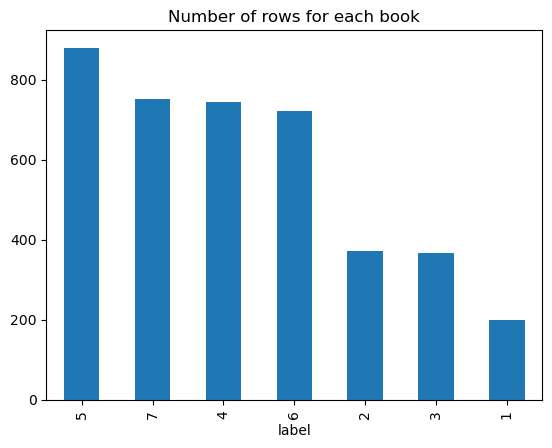

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns

df_random['label'].value_counts().plot(kind='bar')
plt.title('Number of rows for each book')

### 4.1 - The first baseline
Since the books are of different length, we define the first baseline as the largest books share in the total amount of pages.

In [25]:
total_samples = len(df_random)

most_frequent_book_count = df_random['label'].value_counts().max()

# Define the baseline accuracy, always predicting book 5.
baseline_accuracy = most_frequent_book_count / total_samples

print("Total length of df:", total_samples)
print("Most frequent book count:", most_frequent_book_count)
print("Baseline accuracy:", baseline_accuracy)


Total length of df: 4039
Most frequent book count: 880
Baseline accuracy: 0.21787571180985393


In [26]:
from sklearn.model_selection import train_test_split

# Split the data
df_training, df_test = train_test_split(df_random, test_size=0.25, random_state=42)

# Check the lengths of the training and test sets
len_training = len(df_training)
len_test = len(df_test)
labels = [str(label) for label in sorted(df_training['label'].unique())]

print("Length of training set:", len_training)
print("Length of test set:", len_test)
print(labels)

Length of training set: 3029
Length of test set: 1010
['1', '2', '3', '4', '5', '6', '7']


In [27]:
print(df_test.head())

      Page                                               Text  \
3138   770  “Who are you?” said a voice. Harry looked left...   
149    215  When the bell rang to signal the start of afte...   
2023   278  she and Dean were cozily closeted in Madam Pud...   
2446   320  Harry had no reason to regret his choice once ...   
3201   511  Hermione pulled it toward her and began siphon...   

                                                 Tokens  label  
3138  [say, voice, Harry, look, leave, chestnut, bod...      5  
149   [bell, ring, signal, start, afternoon, lesson,...      4  
2023  [Dean, cozily, closet, Madam, Puddifoot, Tea, ...      6  
2446  [Harry, reason, regret, choice, see, Dean, fly...      6  
3201  [Hermione, pull, begin, siphon, ink, wand, go,...      6  


### 4.2 - Naive Bayes Classifier

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
clf_NB = make_pipeline(CountVectorizer(tokenizer=tokenization), MultinomialNB())
clf_NB.fit(df_training['Text'], df_training['label'])

NB_predictions = clf_NB.predict(df_test['Text'])

report_NB = classification_report(df_test['label'], NB_predictions, target_names=labels)

print(report_NB)

              precision    recall  f1-score   support

           1       0.85      0.42      0.56        52
           2       0.92      0.36      0.51        98
           3       0.81      0.56      0.66        89
           4       0.88      0.75      0.81       196
           5       0.53      0.92      0.67       218
           6       0.83      0.73      0.77       170
           7       0.92      0.93      0.92       187

    accuracy                           0.74      1010
   macro avg       0.82      0.67      0.70      1010
weighted avg       0.80      0.74      0.74      1010



#### COMMENT
As we can see, we obtain a high accuracy when just applying a Naive Bayes classifier to the text. This is not strange, since many named entities and such will be over-represented in some books.

### 4.3 - KNearest classifier

In [29]:
from sklearn.neighbors import KNeighborsClassifier

clf_KNN = make_pipeline(CountVectorizer(), KNeighborsClassifier(n_neighbors=9))
clf_KNN.fit(df_training['Text'], df_training['label'])

KNN_predictions = clf_KNN.predict(df_test['Text'])

report_KNN = classification_report(df_test['label'], KNN_predictions, target_names=labels)
print(report_KNN)

              precision    recall  f1-score   support

           1       0.67      0.12      0.20        52
           2       0.19      0.32      0.24        98
           3       0.32      0.13      0.19        89
           4       0.39      0.31      0.35       196
           5       0.41      0.20      0.27       218
           6       0.30      0.59      0.39       170
           7       0.43      0.47      0.45       187

    accuracy                           0.34      1010
   macro avg       0.39      0.30      0.30      1010
weighted avg       0.38      0.34      0.32      1010



### 4.4 - SVM Classifier

In [30]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

clf_SVM = make_pipeline(TfidfVectorizer(stop_words='english', tokenizer=tokenization), SVC(kernel='linear'))
clf_SVM.fit(df_training['Text'], df_training['label'])

SVM_predictions = clf_SVM.predict(df_test['Text'])

report_SVM = classification_report(df_test['label'], SVM_predictions, target_names=labels)
print(report_SVM)

/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           1       0.87      0.75      0.80        52
           2       0.75      0.79      0.77        98
           3       0.82      0.78      0.80        89
           4       0.86      0.80      0.83       196
           5       0.74      0.88      0.80       218
           6       0.85      0.84      0.84       170
           7       0.95      0.88      0.91       187

    accuracy                           0.83      1010
   macro avg       0.83      0.81      0.82      1010
weighted avg       0.84      0.83      0.83      1010



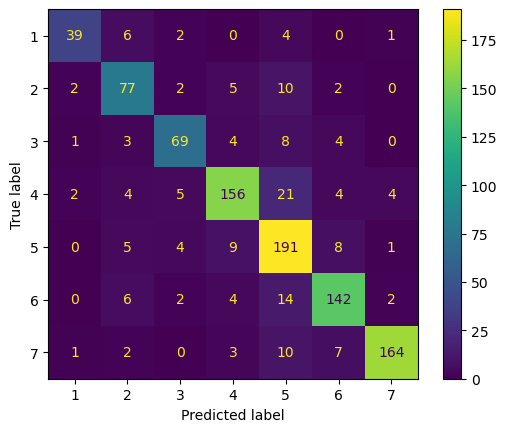

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(df_test['label'], SVM_predictions, labels=clf_SVM.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf_SVM.classes_)
disp.plot()

### 4.5 - Tree based classifiers

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

# the parameters for grid search, just chose the tfidf__max_df as i did in a lab. clf__n_estimators was chosen arbitrary, with some 
# insights from stackoveflow.
parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20, 30]
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=5)
grid_search.fit(df_training['Text'], df_training['label'])

# Best parameters
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

# Evaluate the best model on the test set
best_clf = grid_search.best_estimator_
predictions = best_clf.predict(df_test['Text'])
report_RF = classification_report(df_test['label'], predictions, target_names=labels)
print(report_RF)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
clf__max_depth: None
clf__n_estimators: 200
tfidf__max_df: 0.5
tfidf__ngram_range: (1, 1)
              precision    recall  f1-score   support

           1       1.00      0.19      0.32        52
           2       1.00      0.41      0.58        98
           3       1.00      0.37      0.54        89
           4       0.83      0.72      0.77       196
           5       0.53      0.90      0.67       218
           6       0.69      0.78      0.73       170
           7       0.90      0.93      0.92       187

    accuracy                           0.72      1010
   macro avg       0.85      0.62      0.65      1010
weighted avg       0.80      0.72      0.71      1010



### COMMENTS
We see that all classifiers managed to obtain reasonable results, except for the KNearest. SVM achieved an accuracy of 0.87, considered high even though the pattern is simple to identify. 

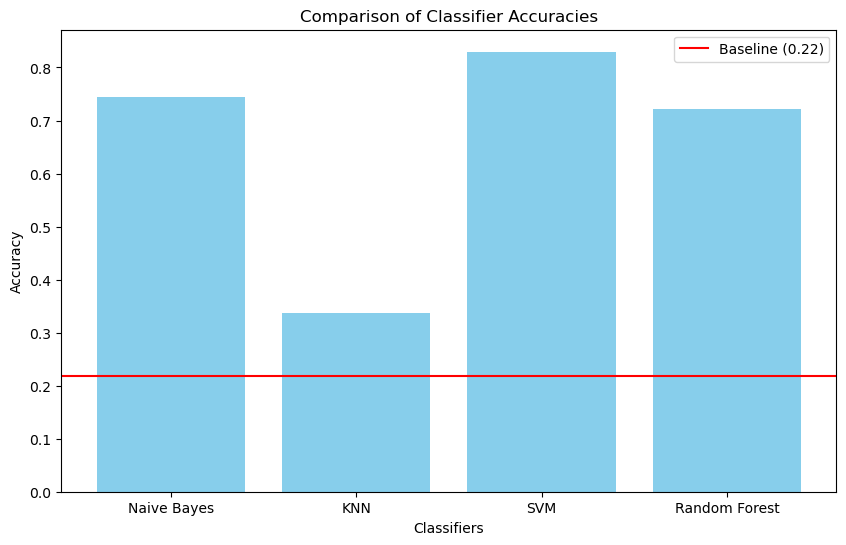

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Accuracy for every classifier
accuracy_NB = accuracy_score(df_test['label'], clf_NB.predict(df_test['Text']))
accuracy_KNN = accuracy_score(df_test['label'], clf_KNN.predict(df_test['Text']))
accuracy_SVM = accuracy_score(df_test['label'], clf_SVM.predict(df_test['Text']))
accuracy_RF = accuracy_score(df_test['label'], best_clf.predict(df_test['Text']))

# Create lists for plotting
classifiers = ['Naive Bayes', 'KNN', 'SVM', 'Random Forest']
accuracies = [accuracy_NB, accuracy_KNN, accuracy_SVM, accuracy_RF]
baseline = [baseline_accuracy] * len(classifiers)  # Assuming baseline_accuracy is calculated

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracies, color='skyblue')
plt.axhline(y=baseline_accuracy, color='r', linestyle='-', label=f'Baseline ({baseline_accuracy:.2f})')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracies')
plt.legend()
plt.show()

## Part 5 Balanced data sets
I will now not only randomize the splitting into training and test, but make sure the representation of each book i fractionally equal.
Has this been a problem in part 4? Maybe not, but it it reasonable to make these adjustments to investigate if it changes anything!

In [34]:
from sklearn.model_selection import train_test_split

# Split the data with stratification, meaning the representation fraction is stil the same as in the entire dataset.
df_training_strat, df_test_strat = train_test_split(df_random, test_size=0.25, random_state=42, stratify=df_random['label'])

### 5.1 - Naive Bayes and SVM with stratified data

In [35]:
clf_NB_stratified = make_pipeline(CountVectorizer(tokenizer=tokenization), MultinomialNB())
clf_NB_stratified.fit(df_training_strat['Text'], df_training_strat['label'])

NB_predictions_strat = clf_NB_stratified.predict(df_test_strat['Text'])

report_NB_strat = classification_report(df_test_strat['label'], NB_predictions_strat, target_names=labels)

print(report_NB_strat)

              precision    recall  f1-score   support

           1       0.79      0.38      0.51        50
           2       0.92      0.39      0.55        93
           3       0.86      0.47      0.61        92
           4       0.81      0.72      0.76       186
           5       0.52      0.93      0.67       220
           6       0.84      0.69      0.76       181
           7       0.91      0.93      0.92       188

    accuracy                           0.73      1010
   macro avg       0.81      0.64      0.68      1010
weighted avg       0.79      0.73      0.72      1010



In [36]:
clf_SVM_stratified = make_pipeline(TfidfVectorizer(stop_words="english", tokenizer=tokenization), SVC(kernel='linear'))
clf_SVM_stratified.fit(df_training_strat['Text'], df_training_strat['label'])

SVM_predictions_strat = clf_SVM_stratified.predict(df_test_strat['Text'])

report_SVM_strat = classification_report(df_test_strat['label'], SVM_predictions_strat, target_names=labels)
print(report_SVM_strat)

/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           1       0.91      0.78      0.84        50
           2       0.81      0.72      0.76        93
           3       0.89      0.77      0.83        92
           4       0.78      0.81      0.79       186
           5       0.73      0.84      0.78       220
           6       0.90      0.87      0.88       181
           7       0.96      0.92      0.94       188

    accuracy                           0.83      1010
   macro avg       0.85      0.82      0.83      1010
weighted avg       0.84      0.83      0.84      1010



### Comments
By stratifying the data, we managed to obtain even slightly higher accuracy. Kernels linear, sigmoid and poly was tested but linear gave the best results!

### 5.2 - Balancing the data with equal support
To further evaluate the performance of the classifiers, the data will be manipulated again with undersampling to have equal representation.

In [37]:
# Find the minimum support for any book
min_support = df_random['label'].value_counts().min()

# Randomly sample pages from each book
sampled_dfs = []
for book_label in df_random['label'].unique():
    book_sample = df_random[df_random['label'] == book_label].sample(n=min_support, random_state=random_seed)
    sampled_dfs.append(book_sample)

balanced_df = pd.concat(sampled_dfs, ignore_index=True)

df_training_balanced, df_test_balanced = train_test_split(balanced_df, test_size=0.25, random_state=111)

# Verifying the distributions
print("Balanced Training set distribution:\n", df_training_balanced['label'].value_counts())
print("Balanced Test set distribution:\n", df_test_balanced['label'].value_counts())


Balanced Training set distribution:
 label
3    157
7    151
6    150
2    150
5    149
4    146
1    141
Name: count, dtype: int64
Balanced Test set distribution:
 label
1    58
4    53
5    50
2    49
6    49
7    48
3    42
Name: count, dtype: int64


### 5.3 - Classify with balanced data

In [38]:
clf_NB_balanced = make_pipeline(CountVectorizer(), MultinomialNB())
clf_NB_balanced.fit(df_training_balanced['Text'], df_training_balanced['label'])

NB_predictions_balanced = clf_NB_balanced.predict(df_test_balanced['Text'])

report_NB_balanced = classification_report(df_test_balanced['label'], NB_predictions_balanced, target_names=labels)

print(report_NB_balanced)

              precision    recall  f1-score   support

           1       0.53      1.00      0.69        58
           2       0.94      0.59      0.72        49
           3       0.64      0.64      0.64        42
           4       0.90      0.53      0.67        53
           5       0.63      0.78      0.70        50
           6       0.90      0.53      0.67        49
           7       0.86      0.79      0.83        48

    accuracy                           0.70       349
   macro avg       0.77      0.70      0.70       349
weighted avg       0.77      0.70      0.70       349



In [39]:
clf_SVM_balanced = make_pipeline(TfidfVectorizer(stop_words="english", tokenizer=tokenization), SVC(kernel='linear'))
clf_SVM_balanced.fit(df_training_balanced['Text'], df_training_balanced['label'])

SVM_predictions_balanced = clf_SVM_balanced.predict(df_test_balanced['Text'])

report_SVM_balanced = classification_report(df_test_balanced['label'], SVM_predictions_balanced, target_names=labels)
print(report_SVM_balanced)

/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           1       0.79      0.93      0.86        58
           2       0.72      0.90      0.80        49
           3       0.73      0.71      0.72        42
           4       0.84      0.58      0.69        53
           5       0.67      0.74      0.70        50
           6       0.80      0.76      0.78        49
           7       0.95      0.81      0.88        48

    accuracy                           0.78       349
   macro avg       0.79      0.78      0.78       349
weighted avg       0.79      0.78      0.78       349



## Part 6 - Clustering 
In order to get some further understanding of the key tokens etc behind the classifications, I will perform some simple clustering and topic modelling and interpret the results.

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

corpus = df_random['Text']

vectorizer = TfidfVectorizer(stop_words='english', tokenizer=tokenization)
X = vectorizer.fit_transform(corpus)

num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
clusters = kmeans.fit_predict(X)

In [93]:
feature_names = vectorizer.get_feature_names_out()

top_terms_per_cluster = {}
for i in range(num_clusters):
    # Get indices of top features for this cluster
    centroid = kmeans.cluster_centers_[i]
    top_features_indices = centroid.argsort()[-20:][::-1]  # Get indices of top 20 features

    # Map indices to terms to enable interpretation
    top_terms = [feature_names[index] for index in top_features_indices]
    top_terms_per_cluster[i] = top_terms

# Display top terms for each cluster
for cluster_num, terms in top_terms_per_cluster.items():
    print(f"Cluster {cluster_num}: {', '.join(terms)}")


Cluster 0: weasley, mrs, mr, say, harry, fred, george, ron, look, percy, ginny, sirius, arthur, know, hermione, think, crouch, eye, door, like
Cluster 1: professor, mcgonagall, say, harry, trelawney, umbridge, snape, dumbledore, look, potter, class, ron, hermione, student, think, tell, lupin, voice, know, eye
Cluster 2: harry, say, ron, hermione, look, know, think, come, like, tell, ginny, ask, neville, want, fred, right, time, try, room, door
Cluster 3: harry, dumbledore, say, snape, voldemort, know, wand, look, think, eye, sirius, face, hand, death, feel, like, potter, tell, lupin, time
Cluster 4: vernon, uncle, dobby, dudley, harry, aunt, petunia, say, dursley, sir, elf, potter, look, marge, winky, house, room, mr, kitchen, letter
Cluster 5: malfoy, harry, say, ron, crabbe, slytherin, goyle, hermione, look, wood, gryffindor, team, draco, snape, potter, broom, bludger, snitch, weasley, tell
Cluster 6: hagrid, ter, yeh, say, harry, hermione, ron, o, look, know, yer, don, fer, dumbledo

### Part 6.1 - Cluster Analyzis 
In order to examine the clustering, we analyze the cluster sizes, the top words and other things that tells us something about the clustering.

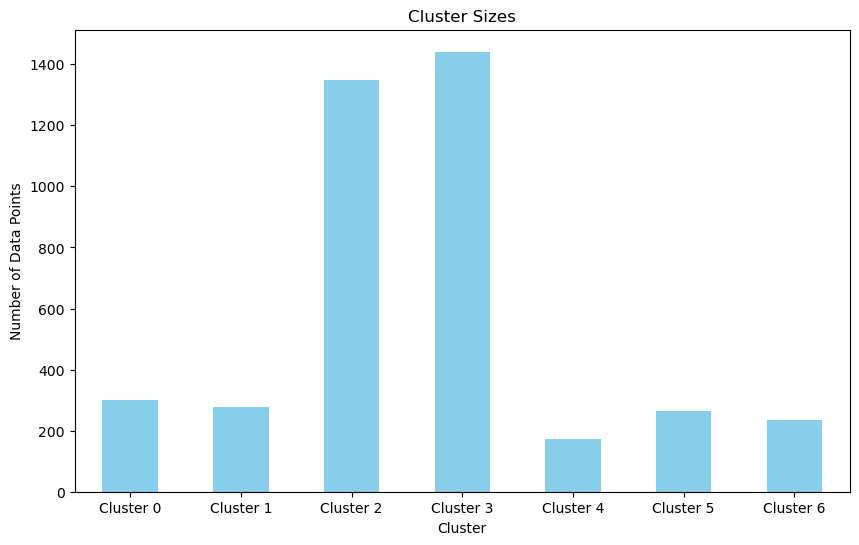

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute cluster sizes
cluster_sizes = pd.Series(clusters).value_counts().sort_index()

# Plot cluster sizes
plt.figure(figsize=(10, 6))
cluster_sizes.plot(kind='bar', color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Cluster Sizes')
plt.xticks(range(num_clusters), [f'Cluster {i}' for i in range(num_clusters)], rotation=0)
plt.show()


Cluster       0   1    2   3   4    5    6
Actual Book                               
1             0  15    4  41  23   59   57
2            32  17   50  25  14  110  125
3             0  36   12  32  16  141  130
4             7  36  119  43  19  336  184
5             0  50  112  55  30  355  278
6            43  66   56  31   8  317  202
7             5  43   51  15  14  447  178


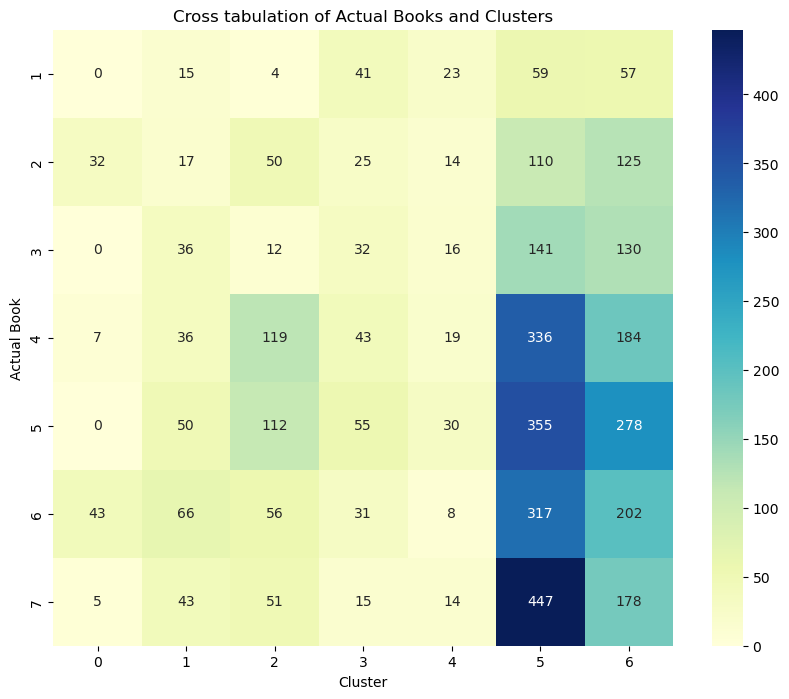

In [43]:
import seaborn as sns

# Creating a cross-tabulation to investigate results
cross_tab = pd.crosstab(df_random['label'], clusters, rownames=['Actual Book'], colnames=['Cluster'])

print(cross_tab)

# Visualize the cross-tabulation as a heatmap, easy to read.
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Cross tabulation of Actual Books and Clusters")
plt.show()


### 6.2 - Evaluation Metrics
These where ran just to check the output really, not a major part of the findings...

In [44]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X, clusters)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.009844376477099317


In [45]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_index = adjusted_rand_score(df_random['label'], clusters)
print("Adjusted Rand Index:", adjusted_rand_index)


Adjusted Rand Index: 0.019150497104344938


In [46]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

homogeneity = homogeneity_score(df_random['label'], clusters)
completeness = completeness_score(df_random['label'], clusters)
v_measure = v_measure_score(df_random['label'], clusters)

print("Homogeneity Score:", homogeneity)
print("Completeness Score:", completeness)
print("V-Measure Score:", v_measure)


Homogeneity Score: 0.032088173128753915
Completeness Score: 0.03996604241655576
V-Measure Score: 0.03559645410412197


### 6.3 - Key words and centroids
To understand the poor performance of the clustering algotihm, we need to examine each clusters closer than just applying known metrics. Therefore, we will now move on to extracting key features and interpret them manually!

In [95]:
# Calc the centroids of the clusters
centroids = kmeans.cluster_centers_

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

n = 10

for cluster_num in range(num_clusters):
    # Sort the features of each cluster in descending order
    sorted_features = centroids[cluster_num].argsort()[::-1]
    
    top_features = [feature_names[i] for i in sorted_features[:n]]
    print(f"Cluster {cluster_num}: {', '.join(top_features)}")


Cluster 0: weasley, mrs, mr, say, harry, fred, george, ron, look, percy
Cluster 1: professor, mcgonagall, say, harry, trelawney, umbridge, snape, dumbledore, look, potter
Cluster 2: harry, say, ron, hermione, look, know, think, come, like, tell
Cluster 3: harry, dumbledore, say, snape, voldemort, know, wand, look, think, eye
Cluster 4: vernon, uncle, dobby, dudley, harry, aunt, petunia, say, dursley, sir
Cluster 5: malfoy, harry, say, ron, crabbe, slytherin, goyle, hermione, look, wood
Cluster 6: hagrid, ter, yeh, say, harry, hermione, ron, o, look, know


### 6.4 - Hierarchical Clustering

In [48]:
from sklearn.cluster import AgglomerativeClustering

corpus = df_random['Text']

vectorizer = TfidfVectorizer(stop_words='english', tokenizer=tokenization)
X = vectorizer.fit_transform(corpus)

# Apply hierarchical clustering. Euclidean metric and ward linkage chosen because most used.
num_clusters = 7 
hierarchical_clustering = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
clusters_hc = hierarchical_clustering.fit_predict(X.toarray())


/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


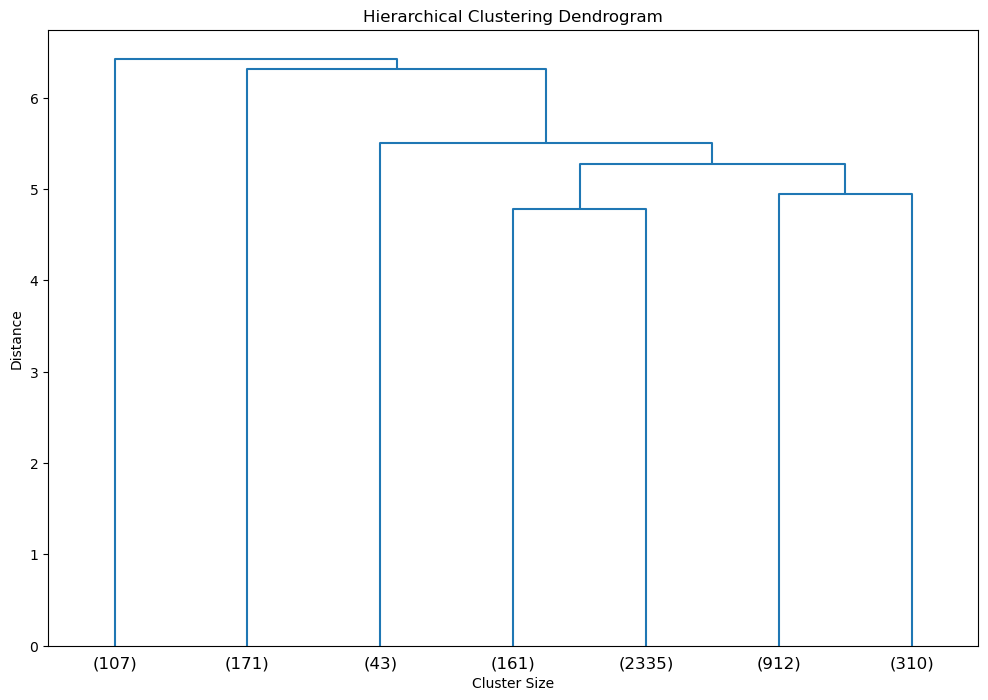

In [49]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Matrix = linkage(X.toarray(), 'ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Matrix, p=num_clusters, truncate_mode='lastp')
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()


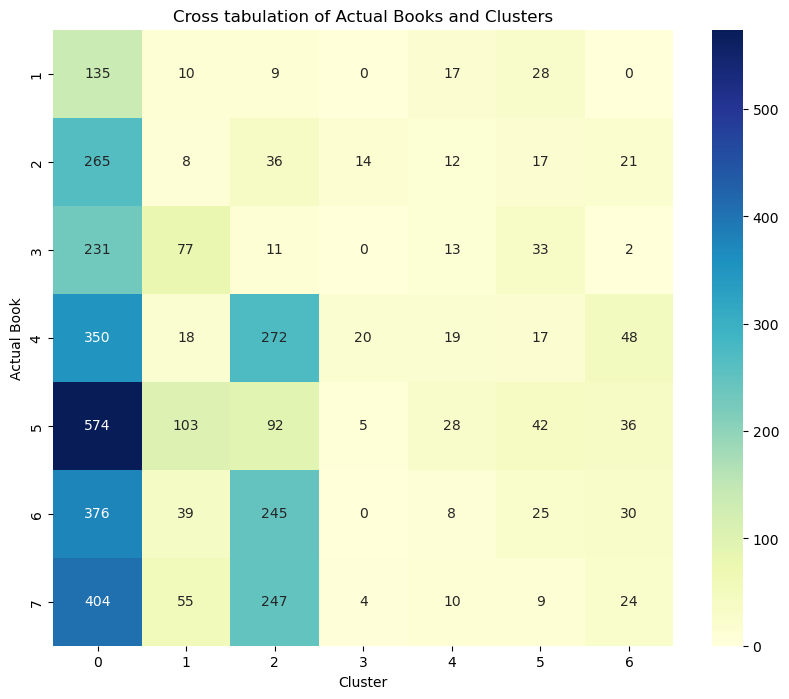

In [50]:
import pandas as pd
import seaborn as sns

cross_tab = pd.crosstab(df_random['label'], clusters_hc, rownames=['Actual Book'], colnames=['Cluster'])

# Visualize the cross-tabulation as a heatmap, easy to read.
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Cross tabulation of Actual Books and Clusters")
plt.show()


In [51]:
cluster_docs = {}
for i in range(num_clusters):
    cluster_docs[i] = [corpus[j] for j in range(len(clusters_hc)) if clusters_hc[j] == i]


In [52]:
from collections import Counter

# Increase the max_length of the spacy model, could not read it otherwise.
nlp.max_length = 5000000 

cluster_word_freq = {}
for cluster_num, docs in cluster_docs.items():
    # Combine all documents in this cluster into one large string
    text = " ".join(docs)
    # Tokenize and count word frequencies
    tokens = tokenization(text)
    word_freq = Counter(tokens)
    cluster_word_freq[cluster_num] = word_freq



In [53]:
n = 20
top_terms_per_cluster = {}

for cluster_num, word_freq in cluster_word_freq.items():
    top_terms = [word for word, freq in word_freq.most_common(n)]
    top_terms_per_cluster[cluster_num] = top_terms


In [54]:
for cluster_num, terms in top_terms_per_cluster.items():
    print(f"Cluster {cluster_num}: {', '.join(terms)}")


Cluster 0: Harry, say, Ron, Hermione, look, know, think, go, get, like, Professor, come, tell, see, time, Dumbledore, hand, face, eye, right
Cluster 1: Harry, say, Snape, Sirius, look, Lupin, know, Hermione, Ron, Dumbledore, think, Kreacher, tell, Professor, go, like, eye, face, come, turn
Cluster 2: Harry, say, Dumbledore, look, know, think, wand, Voldemort, Hermione, Ron, tell, eye, like, see, come, hand, go, face, time, get
Cluster 3: Dobby, Harry, say, sir, elf, Potter, Winky, look, Hermione, know, like, house, Ron, eye, come, get, head, hand, think, squeak
Cluster 4: Harry, Vernon, Uncle, say, Dudley, Aunt, Petunia, look, go, know, room, Dursleys, like, think, come, hand, face, get, Weasley, Marge
Cluster 5: Hagrid, Harry, say, Hermione, ter, look, yeh, Ron, know, get, like, come, go, tell, Dumbledore, think, o, eye, see, hear
Cluster 6: say, Weasley, Harry, Ron, look, Hermione, get, know, Fred, George, Ginny, think, like, come, tell, hand, go, Malfoy, door, Bill


In [55]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

corpus = df_random['Text']

vectorizer = CountVectorizer(stop_words='english', tokenizer=tokenization)
X = vectorizer.fit_transform(corpus)

n_topics = 7

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(X)

# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Displaying topics
no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Topic 0:
ron say harry hermione look weasley fred think george know
Topic 1:
professor harry say mcgonagall uncle vernon umbridge aunt look dudley
Topic 2:
harry wand say ron look hand hermione face eye foot
Topic 3:
harry dobby room door sir look corridor say wall elf
Topic 4:
say harry mr weasley fudge minister look team wood ministry
Topic 5:
malfoy harry snape goyle crabbe hall potter look draco filch
Topic 6:
say harry dumbledore know look think hermione hagrid tell like


## 7 - Clustering with stop words lists
As an alternative to named entity recognition, we can create stop word lists to affect what words are included.

In [56]:
from sklearn.feature_extraction import text 

harry_potter_firstnames = [
    "ab", "aberforth", "alastor", "albus", "alic", "andromeda", "angel", "anthony", "antioch",
    "anton", "arab", "aragog", "argus", "ariana", "armando", "arthur", "auror", "barty",
    "bellatrix", "bernadette", "bill", "blaise", "bloody", "british", "buckbeak", "cadmus",
    "cedric", "chadwick", "charlie", "cho", "colin", "cornelius", "credence", "creevey",
    "crookshanks", "dean", "death", "delph", "dementors", "dobby", "dolores", "draco",
    "dudley", "dumbledore", "eater", "eaters", "elphias", "ernie", "eulalie", "fantastic",
    "fawkes", "fenrir", "filius", "fleur", "fred", "gabrielle", "garrick", "gellert",
    "george", "ginny", "gnarlak", "godric", "golden", "gregory", "gryffindor", "hannah",
    "harry", "hedwig", "helena", "helga", "henry", "hermione", "hogwarts", "horace",
    "house", "hufflepuff", "hugo", "ilvermorny", "isolt", "jacob", "james", "justin",
    "katie", "kendra", "kingsley", "kreacher", "langdon", "lavender", "lee", "leta",
    "lily", "list", "lord", "lucius", "luna", "martha", "mary", "minerva", "modesty",
    "molly", "mr", "mrs", "nagini", "narcissa", "nearly", "neville", "newt", "nicholas",
    "nicolas", "nymphadora", "oliver", "olympe", "order", "padma", "pansy", "parvati",
    "peeves", "penelope", "percival", "percy", "peter", "petunia", "pickett", "pius",
    "pomona", "poppy", "quirinus", "ravenclaw", "remus", "rita", "ron", "rose", "rowena",
    "rubeus", "salazar", "scorpius", "seamus", "seraphina", "serpent", "severus", "sir",
    "sirius", "slytherin", "susan", "sybill", "tales", "teddy", "the", "theseus",
    "vern", "victoire", "viktor", "vincent", "vinda"
]
harry_potter_surnames = [
    "dumbledore", "moody", "potter", "spinnet", "tonks", "johnson", "goldstein", "peverell",
    "dolohov", "figg", "aragog", "filch", "dippet", "weasley", "department", "crouch",
    "lestrange", "bernadette", "zabini", "baron", "ministry", "buckbeak", "diggory", "boot",
    "chang", "creevey", "fudge", "barebone", "siblings", "crookshanks", "thomas", "death",
    "eaters", "delphini", "law", "umbridge", "malfoy", "dursley", "army", "doge", "macmillan",
    "hicks", "beasts", "fawkes", "greyback", "flitwick", "delacour", "gabrielle", "ollivander",
    "grindelwald", "gnarlak", "gryffindor", "abbott", "harry", "hedwig", "ravenclaw", "hufflepuff",
    "shaw", "granger", "hogwarts", "slughorn", "house", "hugo", "ilvermorny", "sayre", "kowalski",
    "james", "finch", "fletchley", "bell", "kendra", "shacklebolt", "kreacher", "langdon", "brown",
    "jordan", "lestrange", "lily", "list", "voldemort", "lucius", "lovegood", "steward", "barebone",
    "mcgonagall", "modesty", "molly", "granger", "nagini", "narcissa", "nick", "longbottom", "scamander",
    "flamel", "nicolas", "tonks", "wood", "maxime", "order", "patil", "parkinson", "peeves", "clearwater",
    "graves", "percy", "pettigrew", "petunia", "pickett", "thicknesse", "sprout", "pomfrey", "quirrell",
    "ravenclaw", "lupin", "skeeter", "ron", "rose", "rowena", "rubeus", "salazar", "scorpius", "seamus",
    "picquery", "serpent", "severus", "luckless", "sirius", "slytherin", "bones", "trelawney", "teddy",
    "alliance", "tales", "weasleys", "theseus", "vern", "victoire", "viktor", "crabbe", "rosier"
]

character_stop_words = harry_potter_firstnames + harry_potter_surnames
english_stop_words = list(text.ENGLISH_STOP_WORDS)
combined_stop_words = english_stop_words + character_stop_words


In [57]:
def display_top_terms_kmeans(model, feature_names, n_top_words):
    for cluster_num, centroid in enumerate(model.cluster_centers_):
        print(f"Cluster {cluster_num}: ", end='')
        print(", ".join([feature_names[i] for i in centroid.argsort()[:-n_top_words - 1:-1]]))

def display_top_terms_lda(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}: ", end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


### 7.1 - KMeans and LDA with custom stop word list

As there was lists of surnames and firstnames available, I will pass them to the vectorizer as additional stop words!

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

corpus = df_random['Text']

# For KMeans clustering
tfidf_vectorizer = TfidfVectorizer(stop_words=combined_stop_words, tokenizer=tokenization)
X_tfidf = tfidf_vectorizer.fit_transform(corpus)
kmeans = KMeans(n_clusters=7, n_init='auto')
clusters_kmeans = kmeans.fit_predict(X_tfidf)

# For LDA topic modeling
count_vectorizer = CountVectorizer(stop_words=combined_stop_words, tokenizer=tokenization)
X_count = count_vectorizer.fit_transform(corpus)
lda = LatentDirichletAllocation(n_components=7, random_state=0)
topics_lda = lda.fit_transform(X_count)



/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['beast', 'bone', 'crookshank', 'dementor', 'dolore', 'elphia', 'fawke', 'fre', 'grave', 'hick', 'hogwart', 'nichola', 'peeve', 'rise', 'sibling', 'tale', 'tonk'] not in stop_words.
  warnings.warn(


In [59]:
n_top_words = 15
print("\nTop terms per cluster (KMeans):")
display_top_terms_kmeans(kmeans, tfidf_vectorizer.get_feature_names_out(), n_top_words)



Top terms per cluster (KMeans):
Cluster 0: vernon, uncle, aunt, say, marge, look, letter, kitchen, room, car, owl, like, living, boy, time
Cluster 1: say, look, know, think, tell, want, like, come, ask, yeah, right, oh, good, voice, time
Cluster 2: say, know, look, think, tell, time, year, hogwart, want, ask, leave, like, feel, day, come
Cluster 3: professor, say, look, class, student, think, hall, tell, eye, table, voice, know, sit, teacher, turn
Cluster 4: wand, say, look, door, hand, eye, face, stand, head, foot, come, light, like, voice, feel
Cluster 5: snape, say, professor, look, dark, know, wand, eye, think, tell, face, potion, office, black, try
Cluster 6: hagrid, ter, yeh, say, o, look, know, yer, don, fer, fang, tell, bin, cabin, forest


In [60]:

print("\nTop terms per topic (LDA):")
display_top_terms_lda(lda, count_vectorizer.get_feature_names_out(), n_top_words)


Top terms per topic (LDA):
Topic 0: know, wand, say, feel, eye, face, hand, think, look, tell, like, voice, dark, place, long
Topic 1: say, professor, look, snape, think, tell, come, time, know, right, eye, turn, face, good, head
Topic 2: look, door, say, wand, stand, light, like, krum, wall, come, water, room, foot, bagman, open
Topic 3: say, look, know, think, like, tell, come, want, ask, time, uncle, vernon, hogwart, year, good
Topic 4: say, think, look, know, tell, like, want, eye, come, ask, right, wand, hear, black, hand
Topic 5: wand, door, head, floor, foot, look, light, come, say, fall, hand, black, hear, eye, lockhart
Topic 6: hagrid, say, ter, look, yeh, know, like, tell, come, o, head, forest, tree, face, giant


## Part 8 - Classification with stop word list
Since we have created a decent stop word list with named entities, we can try and see what happens when this is applied on classification with Naive Bayes and SVM! This will likely focus more on the semantic content.

### Part 8.1 - Naive Bayes 

In [61]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
clf_NB_sw = make_pipeline(CountVectorizer(stop_words = combined_stop_words, tokenizer = tokenization), MultinomialNB())
clf_NB_sw.fit(df_training['Text'], df_training['label'])

predictions_NB_sw = clf_NB_sw.predict(df_test['Text'])

report_NB_sw = classification_report(df_test['label'], predictions_NB_sw, target_names=labels)

print(report_NB_sw)

              precision    recall  f1-score   support

           1       0.85      0.42      0.56        52
           2       0.96      0.48      0.64        98
           3       0.77      0.54      0.64        89
           4       0.89      0.72      0.79       196
           5       0.53      0.94      0.68       218
           6       0.82      0.65      0.73       170
           7       0.91      0.93      0.92       187

    accuracy                           0.74      1010
   macro avg       0.82      0.67      0.71      1010
weighted avg       0.80      0.74      0.74      1010



### Part 8.2 - SVM 

In [62]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

tf_idf_vectorizer = TfidfVectorizer(stop_words=combined_stop_words, tokenizer=tokenization)
clf_SVM_sw = make_pipeline(tf_idf_vectorizer, SVC(kernel='linear'))
clf_SVM_sw.fit(df_training['Text'], df_training['label'])

SVM_predictions_sw = clf_SVM_sw.predict(df_test['Text'])

report_SVM_sw = classification_report(df_test['label'], SVM_predictions_sw, target_names=labels)
print(report_SVM_sw)

/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['beast', 'bone', 'crookshank', 'dementor', 'dolore', 'elphia', 'fawke', 'fre', 'grave', 'hick', 'hogwart', 'nichola', 'peeve', 'rise', 'sibling', 'tale', 'tonk'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.93      0.73      0.82        52
           2       0.78      0.70      0.74        98
           3       0.85      0.76      0.80        89
           4       0.84      0.75      0.79       196
           5       0.66      0.88      0.76       218
           6       0.80      0.76      0.78       170
           7       0.95      0.89      0.92       187

    accuracy                           0.80      1010
   macro avg       0.83      0.78      0.80      1010
weighted avg       0.82      0.80      0.80      1010



In [63]:
sample_text = df_4[df_4['Page'] == 242]['Text'].iloc[0]

# Transform the sample text
transformed_vector = tf_idf_vectorizer.transform([sample_text])
print(transformed_vector)

  (0, 13978)	0.09660872729995992
  (0, 13714)	0.07710691885564788
  (0, 13526)	0.0544427716624815
  (0, 12672)	0.10247961465439534
  (0, 12515)	0.10414138496208074
  (0, 12277)	0.08551555303733004
  (0, 12171)	0.04929785617929063
  (0, 12037)	0.07620931409406843
  (0, 11921)	0.10828089897742771
  (0, 11677)	0.11014800361710622
  (0, 11666)	0.09563692263275145
  (0, 11523)	0.0676422840263988
  (0, 11254)	0.09703697075041108
  (0, 11121)	0.10009458267262107
  (0, 10979)	0.11407214289739437
  (0, 10858)	0.1899300651994147
  (0, 10773)	0.09836718846348268
  (0, 10647)	0.1557795047647357
  (0, 10485)	0.16455487704924918
  (0, 10409)	0.09703697075041108
  (0, 10384)	0.14214148929759376
  (0, 10251)	0.13070030908375907
  (0, 10002)	0.18661177179218338
  (0, 9615)	0.25777752712499385
  (0, 9612)	0.07797005196133654
  :	:
  (0, 6794)	0.13070030908375907
  (0, 6779)	0.10873486410758051
  (0, 6587)	0.1492836594159577
  (0, 6163)	0.134859391552967
  (0, 6008)	0.11269505791340344
  (0, 5912)	0.1051

In [64]:
words = tf_idf_vectorizer.inverse_transform(transformed_vector)

print(words)

[array(['wrong', 'whisper', 'want', 'trouble', 'touch', 'think', 'tell',
       'table', 'surprise', 'strange', 'straight', 'stare', 'soon',
       'snap', 'slam', 'sign', 'short', 'series', 'scrawl', 'scar', 'say',
       'rumor', 'retirement', 'read', 'reach', 'perplexed', 'owlery',
       'open', 'north', 'news', 'mean', 'mad', 'look', 'letter', 'late',
       'lap', 'land', 'jolt', 'indignantly', 'immediately', 'hurt',
       'hurry', 'hoot', 'hit', 'great', 'good', 'furiously', 'forehead',
       'food', 'fly', 'fist', 'eye', 'expectantly', 'come', 'click',
       'chair', 'breathlessly', 'beak', 'ask', 'aloud'], dtype='<U20')]


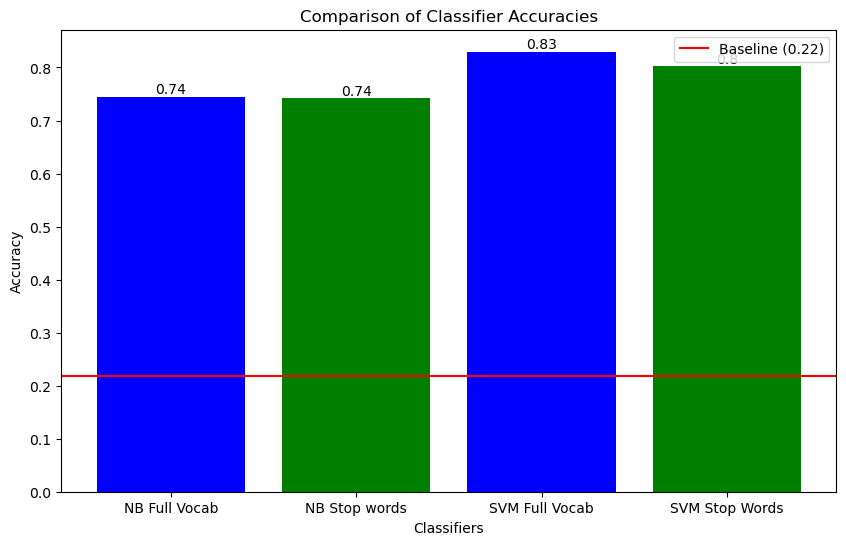

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

accuracy_NB_SW = accuracy_score(df_test['label'], clf_NB_sw.predict(df_test['Text']))
accuracy_SVM_SW = accuracy_score(df_test['label'], clf_SVM_sw.predict(df_test['Text']))

# Prepare data for plotting, comparing with the old results without custom stop words.
classifiers = ['NB Full Vocab', 'NB Stop words', 'SVM Full Vocab', 'SVM Stop Words']
accuracies = [accuracy_NB, accuracy_NB_SW, accuracy_SVM, accuracy_SVM_SW]
baseline = [baseline_accuracy] * len(classifiers) 
colors = ['blue', 'green', 'blue', 'green']  # Colors for each bar

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color=colors)
plt.axhline(y=baseline_accuracy, color='r', linestyle='-', label=f'Baseline ({baseline_accuracy:.2f})')

# Just some plot syntax i copied from stackoverflow...
for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(accuracy, 2), ha='center', va='bottom')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracies')
plt.legend()
plt.show()


## Part 9 - Named Entity Recognition
Since the hypothesis is that the classifiers work mainly on frequently named people, places or phenoms when the pure text is provided, we will have to consider alternative approaches to really evaluate if there are actual language trends that are typical for each book. These named entities kind of "give away" the book sometimes by being to obviously connected to one or a couple of books, and the TfidfVectorizer catches such patterns quite easily. Therefore, this part will aim to identify named entities and replacing them with generic entity tokens. 

In [66]:
# Sample text for NER
sample_text = df_4[df_4['Page'] == 242]['Text'].iloc[0] 
doc = nlp(sample_text)

# Print detected entities and their types
for ent in doc.ents:
    print(ent.text, ent.label_)

Harry PERSON
Harry — I’m PERSON
Dumbledore PERSON
Mad-Eye ORG
Ron PERSON
Harry PERSON
Harry PERSON
Ron PERSON
Dumbledore PERSON
Ron PERSON
Harry PERSON
Harry PERSON
Hedwig NORP
Harry PERSON
Ron PERSON
Harry PERSON
Hedwig NORP
Ron PERSON
Harry PERSON
Hedwig LOC
Owlery PERSON


In [67]:
def replace_entities_with_tokens(text):
    doc = nlp(text)
    new_text = text
    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'GPE', 'LOC', 'ORG', 'NORP']:
            new_text = new_text.replace(ent.text, ent.label_)
    return new_text


In [68]:
df_ner = df_random[['Page', 'label']].copy()

# Apply NER and replacement to the Text column
df_ner['Text'] = df_random['Text'].apply(replace_entities_with_tokens)


In [69]:
print(df_ner.head())

   Page  label                                               Text
0    57      2  “I said I would buy you a racing broom,” said ...
1   253      3  PERSON, meanwhile, had to fit in his homework ...
2   644      4  PERSON and PERSON stood there in the darkness ...
3   198      3  "With an incantation, which will work only if ...
4   346      6  “Oh, ha ha …” Enjoying the fact that they coul...


In [70]:
print(df_ner[df_ner['Page'] == 455]['Text'].iloc[0]) 

“I was just having some fun,” he says, before hastily changing the subject. As if this were not enough, ORG has now unearthed evidence that NORP is not — as he has always pretended — a pure-blood wizard. He is not, in fact, even pure human. His mother, we can exclusively reveal, is none other than the giantess GPE, whose whereabouts are currently unknown. Bloodthirsty and brutal, the ORG brought themselves to the point of extinction by warring amongst themselves during the last century. The handful that remained joined the ranks of ORG, and were responsible for some of the worst mass Muggle killings of his reign of terror. While many of the ORG who served He-WhoMust-Not-Be-Named were killed by Aurors working against the Dark Side, GPE was not among them. It is possible she escaped to one of the giant communities still existing in foreign mountain ranges. If his antics during ORG lessons are any guide, however, GPE’s son appears to have inherited her brutal nature. In a bizarre twist, N

### Part 9.1 - Classification after extracting NE, Naive Bayes

In [71]:
df_train_random, df_test_random = train_test_split(df_ner, test_size=0.25, random_state=42)
df_train_stratified, df_test_stratified = train_test_split(df_ner, test_size=0.25, random_state=42, stratify=df_ner['label'])


In [72]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
clf_NB_NE = make_pipeline(CountVectorizer(stop_words = 'english', tokenizer = tokenization), MultinomialNB())
clf_NB_NE.fit(df_train_random['Text'], df_train_random['label'])

predictions_NB_NE = clf_NB_NE.predict(df_test_random['Text'])

report_NB_NE = classification_report(df_test_random['label'], predictions_NB_NE, target_names=labels)

print(report_NB_NE)

/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           1       0.93      0.27      0.42        52
           2       0.78      0.18      0.30        98
           3       0.74      0.39      0.51        89
           4       0.77      0.67      0.71       196
           5       0.45      0.89      0.60       218
           6       0.76      0.58      0.66       170
           7       0.90      0.93      0.92       187

    accuracy                           0.66      1010
   macro avg       0.76      0.56      0.59      1010
weighted avg       0.73      0.66      0.64      1010



In [73]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
clf_NB_NE_strat = make_pipeline(CountVectorizer(stop_words = 'english', tokenizer = tokenization), MultinomialNB())
clf_NB_NE_strat.fit(df_train_stratified['Text'], df_train_stratified['label'])

predictions_NB_NE_strat = clf_NB_NE_strat.predict(df_test_stratified['Text'])

report_NB_NE_strat = classification_report(df_test_strat['label'], predictions_NB_NE_strat, target_names=labels)

print(report_NB_NE_strat)

/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           1       0.78      0.28      0.41        50
           2       0.81      0.24      0.37        93
           3       0.80      0.35      0.48        92
           4       0.70      0.67      0.69       186
           5       0.45      0.91      0.61       220
           6       0.84      0.52      0.64       181
           7       0.86      0.89      0.87       188

    accuracy                           0.65      1010
   macro avg       0.75      0.55      0.58      1010
weighted avg       0.72      0.65      0.63      1010



### 9.3 - Classification after NER, SVM

In [74]:
tf_idf_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=tokenization)
clf_SVM_NE = make_pipeline(tf_idf_vectorizer, SVC(kernel='linear'))
clf_SVM_NE.fit(df_train_random['Text'], df_train_random['label'])

SVM_predictions_NE = clf_SVM_NE.predict(df_test_random['Text'])

report_SVM_NE = classification_report(df_test_random['label'], SVM_predictions_NE, target_names=labels)
print(report_SVM_NE)

/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           1       0.97      0.54      0.69        52
           2       0.67      0.48      0.56        98
           3       0.70      0.64      0.67        89
           4       0.73      0.69      0.71       196
           5       0.60      0.81      0.69       218
           6       0.71      0.71      0.71       170
           7       0.90      0.87      0.89       187

    accuracy                           0.72      1010
   macro avg       0.75      0.68      0.70      1010
weighted avg       0.73      0.72      0.72      1010



In [75]:
tf_idf_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=tokenization)
clf_SVM_NE_strat = make_pipeline(tf_idf_vectorizer, SVC(kernel='linear'))
clf_SVM_NE_strat.fit(df_train_stratified['Text'], df_train_stratified['label'])

SVM_predictions_NE_strat = clf_SVM_NE_strat.predict(df_test_stratified['Text'])

report_SVM_NE_strat = classification_report(df_test_stratified['label'], SVM_predictions_NE_strat, target_names=labels)
print(report_SVM_NE_strat)

/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           1       0.94      0.62      0.75        50
           2       0.71      0.49      0.58        93
           3       0.79      0.65      0.71        92
           4       0.73      0.72      0.72       186
           5       0.59      0.78      0.67       220
           6       0.72      0.72      0.72       181
           7       0.91      0.88      0.89       188

    accuracy                           0.73      1010
   macro avg       0.77      0.70      0.72      1010
weighted avg       0.74      0.73      0.73      1010



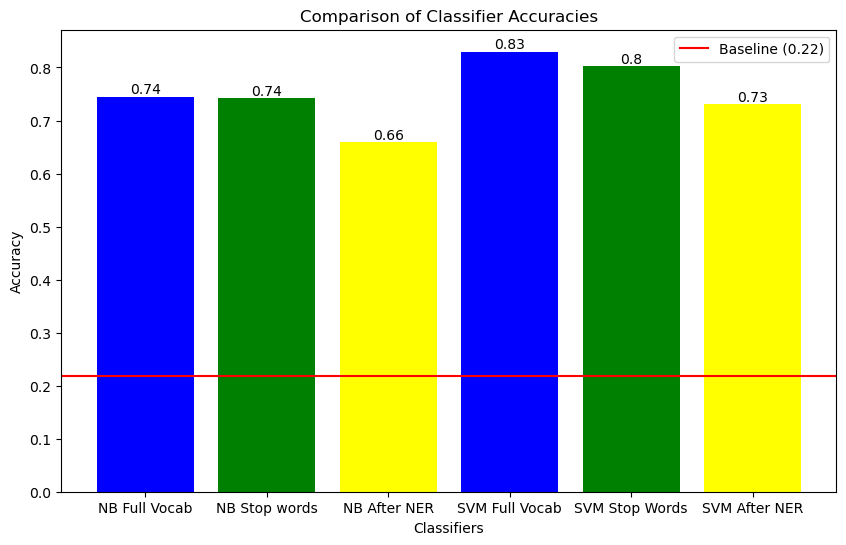

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

accuracy_NB_NE = accuracy_score(df_test_random['label'], clf_NB_NE.predict(df_test_random['Text']))
accuracy_SVM_NE = accuracy_score(df_test_stratified['label'], clf_SVM_NE_strat.predict(df_test_stratified['Text']))

# Prepare data for plotting, comparing with the old results without custom stop words.
classifiers = ['NB Full Vocab', 'NB Stop words', 'NB After NER', 'SVM Full Vocab', 'SVM Stop Words', 'SVM After NER']
accuracies = [accuracy_NB, accuracy_NB_SW, accuracy_NB_NE, accuracy_SVM, accuracy_SVM_SW, accuracy_SVM_NE]
baseline = [baseline_accuracy] * len(classifiers) 
colors = ['blue', 'green', 'yellow', 'blue', 'green', 'yellow']  # Colors for each bar

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color=colors)
plt.axhline(y=baseline_accuracy, color='r', linestyle='-', label=f'Baseline ({baseline_accuracy:.2f})')

# Just some plot syntax i copied from stackoverflow...
for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(accuracy, 2), ha='center', va='bottom')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracies')
plt.legend()
plt.show()

In [86]:
ne_stop_words = ['norp', 'person', 'loc', 'org', 'gpe']
cluster_stop_words = english_stop_words + ne_stop_words

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

corpus = df_ner['Text']

# For KMeans clustering
tfidf_vectorizer = TfidfVectorizer(stop_words=cluster_stop_words, tokenizer=tokenization)
X_tfidf = tfidf_vectorizer.fit_transform(corpus)
kmeans = KMeans(n_clusters=7, n_init='auto')
clusters_kmeans = kmeans.fit_predict(X_tfidf)

# For LDA topic modeling
count_vectorizer = CountVectorizer(stop_words=cluster_stop_words, tokenizer=tokenization)
X_count = count_vectorizer.fit_transform(corpus)
lda = LatentDirichletAllocation(n_components=7, random_state=0)
topics_lda = lda.fit_transform(X_count)


In [83]:
n_top_words = 15
print("\nTop terms per cluster (KMeans):")
display_top_terms_kmeans(kmeans, tfidf_vectorizer.get_feature_names_out(), n_top_words)



Top terms per cluster (KMeans):
Cluster 0: wand, say, hand, look, face, eye, foot, feel, light, fall, like, ground, head, voice, stand
Cluster 1: professor, say, look, class, tell, think, know, yes, eye, turn, good, voice, student, hermione, leave
Cluster 2: door, say, room, look, open, come, corridor, stand, hear, step, know, voice, think, wall, head
Cluster 3: mr, mrs, say, look, know, think, tell, hand, come, wand, eye, like, good, ask, want
Cluster 4: say, know, look, hermione, think, tell, want, like, ask, come, yeah, oh, right, ter, mean
Cluster 5: say, look, year, time, know, think, like, day, good, tell, table, long, come, try, hermione
Cluster 6: elf, sir, say, lord, master, know, house, goblin, dark, think, look, tell, wizard, eye, come


In [84]:

print("\nTop terms per topic (LDA):")
display_top_terms_lda(lda, count_vectorizer.get_feature_names_out(), n_top_words)


Top terms per topic (LDA):
Topic 0: look, say, feel, face, like, ground, eye, head, hand, stand, turn, mr, black, close, hermione
Topic 1: say, know, look, think, tell, want, like, mr, come, time, ask, hermione, good, right, try
Topic 2: professor, say, look, class, room, sit, student, year, hand, think, lesson, teacher, potion, leave, eye
Topic 3: goblin, know, wizard, minister, prime, lord, think, long, say, year, man, little, inside, house, place
Topic 4: wand, look, eye, say, feel, face, stand, voice, know, lord, hand, sword, tell, think, master
Topic 5: wand, say, look, hand, face, door, eye, come, head, like, foot, stand, light, hear, voice
Topic 6: say, look, hermione, come, think, tell, like, door, know, table, room, good, head, right, turn


In [87]:
cluster_stop_words = combined_stop_words + ne_stop_words

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

corpus = df_ner['Text']

# For KMeans clustering
tfidf_vectorizer = TfidfVectorizer(stop_words=cluster_stop_words, tokenizer=tokenization)
X_tfidf = tfidf_vectorizer.fit_transform(corpus)
kmeans = KMeans(n_clusters=7, n_init='auto')
clusters_kmeans = kmeans.fit_predict(X_tfidf)

# For LDA topic modeling
count_vectorizer = CountVectorizer(stop_words=cluster_stop_words, tokenizer=tokenization)
X_count = count_vectorizer.fit_transform(corpus)
lda = LatentDirichletAllocation(n_components=7, random_state=0)
topics_lda = lda.fit_transform(X_count)


/Users/axelandersson/anaconda3/envs/tdde16-project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['beast', 'bone', 'crookshank', 'dementor', 'dolore', 'elphia', 'fawke', 'fre', 'grave', 'hick', 'hogwart', 'nichola', 'peeve', 'rise', 'sibling', 'tale', 'tonk'] not in stop_words.
  warnings.warn(


In [89]:
n_top_words = 15
print("\nTop terms per cluster (KMeans):")
display_top_terms_kmeans(kmeans, tfidf_vectorizer.get_feature_names_out(), n_top_words)


Top terms per cluster (KMeans):
Cluster 0: say, day, look, time, year, owl, book, good, letter, think, room, know, minister, read, tell
Cluster 1: say, know, think, tell, look, ask, want, time, wizard, kill, come, like, feel, hear, thing
Cluster 2: say, look, face, eye, hand, stand, like, hair, table, man, head, voice, come, long, sit
Cluster 3: wand, say, hand, ground, foot, air, fall, scream, light, look, yell, eye, feel, hit, face
Cluster 4: say, look, know, think, tell, want, like, ask, yeah, come, oh, right, ter, good, mean
Cluster 5: professor, say, look, class, think, tell, know, eye, student, turn, voice, sit, yes, good, hand
Cluster 6: door, say, room, open, look, come, corridor, wall, step, stand, hear, staircase, voice, hall, know


In [90]:

print("\nTop terms per topic (LDA):")
display_top_terms_lda(lda, count_vectorizer.get_feature_names_out(), n_top_words)


Top terms per topic (LDA):
Topic 0: say, know, look, wand, minister, hand, long, time, feel, think, leave, eye, boy, wizard, old
Topic 1: say, look, wand, eye, face, hand, come, stand, head, door, foot, voice, like, open, feel
Topic 2: professor, say, look, class, voice, door, know, think, tell, room, hand, open, turn, time, student
Topic 3: say, know, think, tell, want, wand, time, like, try, year, master, come, wizard, look, sure
Topic 4: say, look, door, like, come, hear, head, stand, ground, foot, right, face, hand, long, large
Topic 5: say, look, know, think, tell, like, come, want, ask, good, time, right, oh, thing, leave
Topic 6: hogwart, christmas, year, root, snow, trademark, holly, goblet, gilderoy, mistletoe, publication, copyright, scholastic, illustration, permission
